In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from protscape import datasets, models, utils
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
dm = datasets.TAPEDataModule(dataset='fluorescence', pad=237, batch_size=256)
dm.setup()

# charset = 22
X_train = dm.tape_train.X.transpose(0, 2, 1).reshape(-1, 237*22)
X_test = dm.tape_test.X.transpose(0, 2, 1).reshape(-1, 237*22)

y_train = dm.tape_train.y
y_test = dm.tape_test.y

## GFP baseline

In [5]:
lin = Ridge()
lin.fit(X_train, y_train)

y_pred = lin.predict(X_test)
clip = [min(y_train), max(y_train)]
base_mse, base_spearman = utils.metrics(y_test, y_pred, clip=clip)
params = len(lin.coef_) + 1  # intercept

print(f'Baseline MSE: {base_mse:.3f}')
print(f'Baseline Spearman: {base_spearman:.3f}')
print(f'Parameters: {params:,}')

Baseline MSE: 0.252
Baseline Spearman: 0.691
Parameters: 5,215


## 1-Layer + MaxPool

In [6]:
learning_rates = [1e-3, 0, 5e-6]
weight_decays = [0, 0, 0.05]

encoder_kwargs = {'layers' : 1,
                  'out_channels' : [1024],
                  'kernel_sizes' : [5],
                  'dilations' : [1]}

maxp_model = models.CNNEncoder(learning_rates, weight_decays, 'maxpool', encoder_kwargs)
trainer = pl.Trainer(gpus=1, max_epochs=50)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [7]:
trainer.fit(maxp_model, dm)

C:\Users\edward\Anaconda3\envs\pt_gpu\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
  rank_zero_warn(f"you passed in a {loader_name} but have no {step_name}. Skipping {stage} loop")
C:\Users\edward\Anaconda3\envs\pt_gpu\lib\site-packages\pytorch_lightning\core\datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


fluorescence already downloaded



  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 113 K 
1 | mapper    | Sequential | 0     
2 | predictor | Sequential | 1.0 K 
-----------------------------------------
114 K     Trainable params
0         Non-trainable params
114 K     Total params
0.459     Total estimated model params size (MB)
C:\Users\edward\Anaconda3\envs\pt_gpu\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

In [8]:
preds, true = utils.run_predict(maxp_model, dm.test_dataloader(), device)
maxp_mse, maxp_spearman = utils.metrics(true, preds, clip=clip)

print(f'MaxPool MSE: {maxp_mse:.3f}')
print(f'MaxPool Spearman: {maxp_spearman:.3f}')

MaxPool MSE: 0.271
MaxPool Spearman: 0.683


## 1-Layer + LinearMaxPool

In [37]:
learning_rates = [1e-3, 5e-5, 5e-6]
weight_decays = [0, 0.05, 0.05]

encoder_kwargs = {'layers' : 1,
                  'out_channels' : [1024],
                  'kernel_sizes' : [5],
                  'dilations' : [1]}

linmaxp_model = models.CNNEncoder(learning_rates, weight_decays, 'linear_maxpool', encoder_kwargs)
trainer = pl.Trainer(gpus=1, max_epochs=50)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [38]:
# too many parameters for mapper, not setup correctly?

trainer.fit(linmaxp_model, dm)

C:\Users\edward\Anaconda3\envs\pt_gpu\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
  rank_zero_warn(f"you passed in a {loader_name} but have no {step_name}. Skipping {stage} loop")
C:\Users\edward\Anaconda3\envs\pt_gpu\lib\site-packages\pytorch_lightning\core\datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 113 K 
1 | mapper    | Sequential | 2.1 M 
2 | predictor | Sequential | 2.0 K 
-----------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.860     Total estimated model params size (MB)
C:\U

Training: -1it [00:00, ?it/s]

C:\Users\edward\Anaconda3\envs\pt_gpu\lib\site-packages\pytorch_lightning\core\datamodule.py:423: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


In [39]:
preds, true = utils.run_predict(linmaxp_model, dm.test_dataloader(), device)
linmaxp_mse, linmaxp_spearman = utils.metrics(true, preds, clip=clip)

print(f'LinMaxPool MSE: {linmaxp_mse:.3f}')
print(f'LinMaxPool Spearman: {linmaxp_spearman:.3f}')

LinMaxPool MSE: 0.509
LinMaxPool Spearman: 0.634


In [28]:
def get_embeddings(model, dataloader, device):
    
    model.eval()
    model = model.to(device)
    
    embeddings = []
    y_vals = []
    
    with torch.no_grad():
        for x, y in dataloader:

            x = x.permute(0, 2, 1).to(device).float()

            enc = model.encoder(x)
            emb = model.mapper(enc)

            embeddings.append(emb)
            y_vals.extend(y.numpy())

        embeddings = torch.cat(embeddings, dim=0).detach().cpu().numpy()
    
    return embeddings, np.array(y_vals)

In [79]:
def plot_embeddings(embeddings, y_vals, ax):
    
    pipe = make_pipeline(StandardScaler(), PCA(n_components=2))
    emb_pca = pipe.fit_transform(embeddings)
    
    order = np.argsort(y_vals)
    
    p = ax.scatter(emb_pca[order, 0], emb_pca[order, 1], c=y_vals[order], alpha=0.2, s=2)
    cbar = plt.colorbar(p, label='Log Fluorescence', ax=ax)
    cbar.solids.set(alpha=1)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

In [61]:
learning_rates = [1e-3, 0, 5e-6]
weight_decays = [0, 0, 0.05]

encoder_kwargs = {'layers' : 1,
                  'out_channels' : [1024],
                  'kernel_sizes' : [5],
                  'dilations' : [1]}

random_model = models.CNNEncoder(learning_rates, weight_decays, 'maxpool', encoder_kwargs)

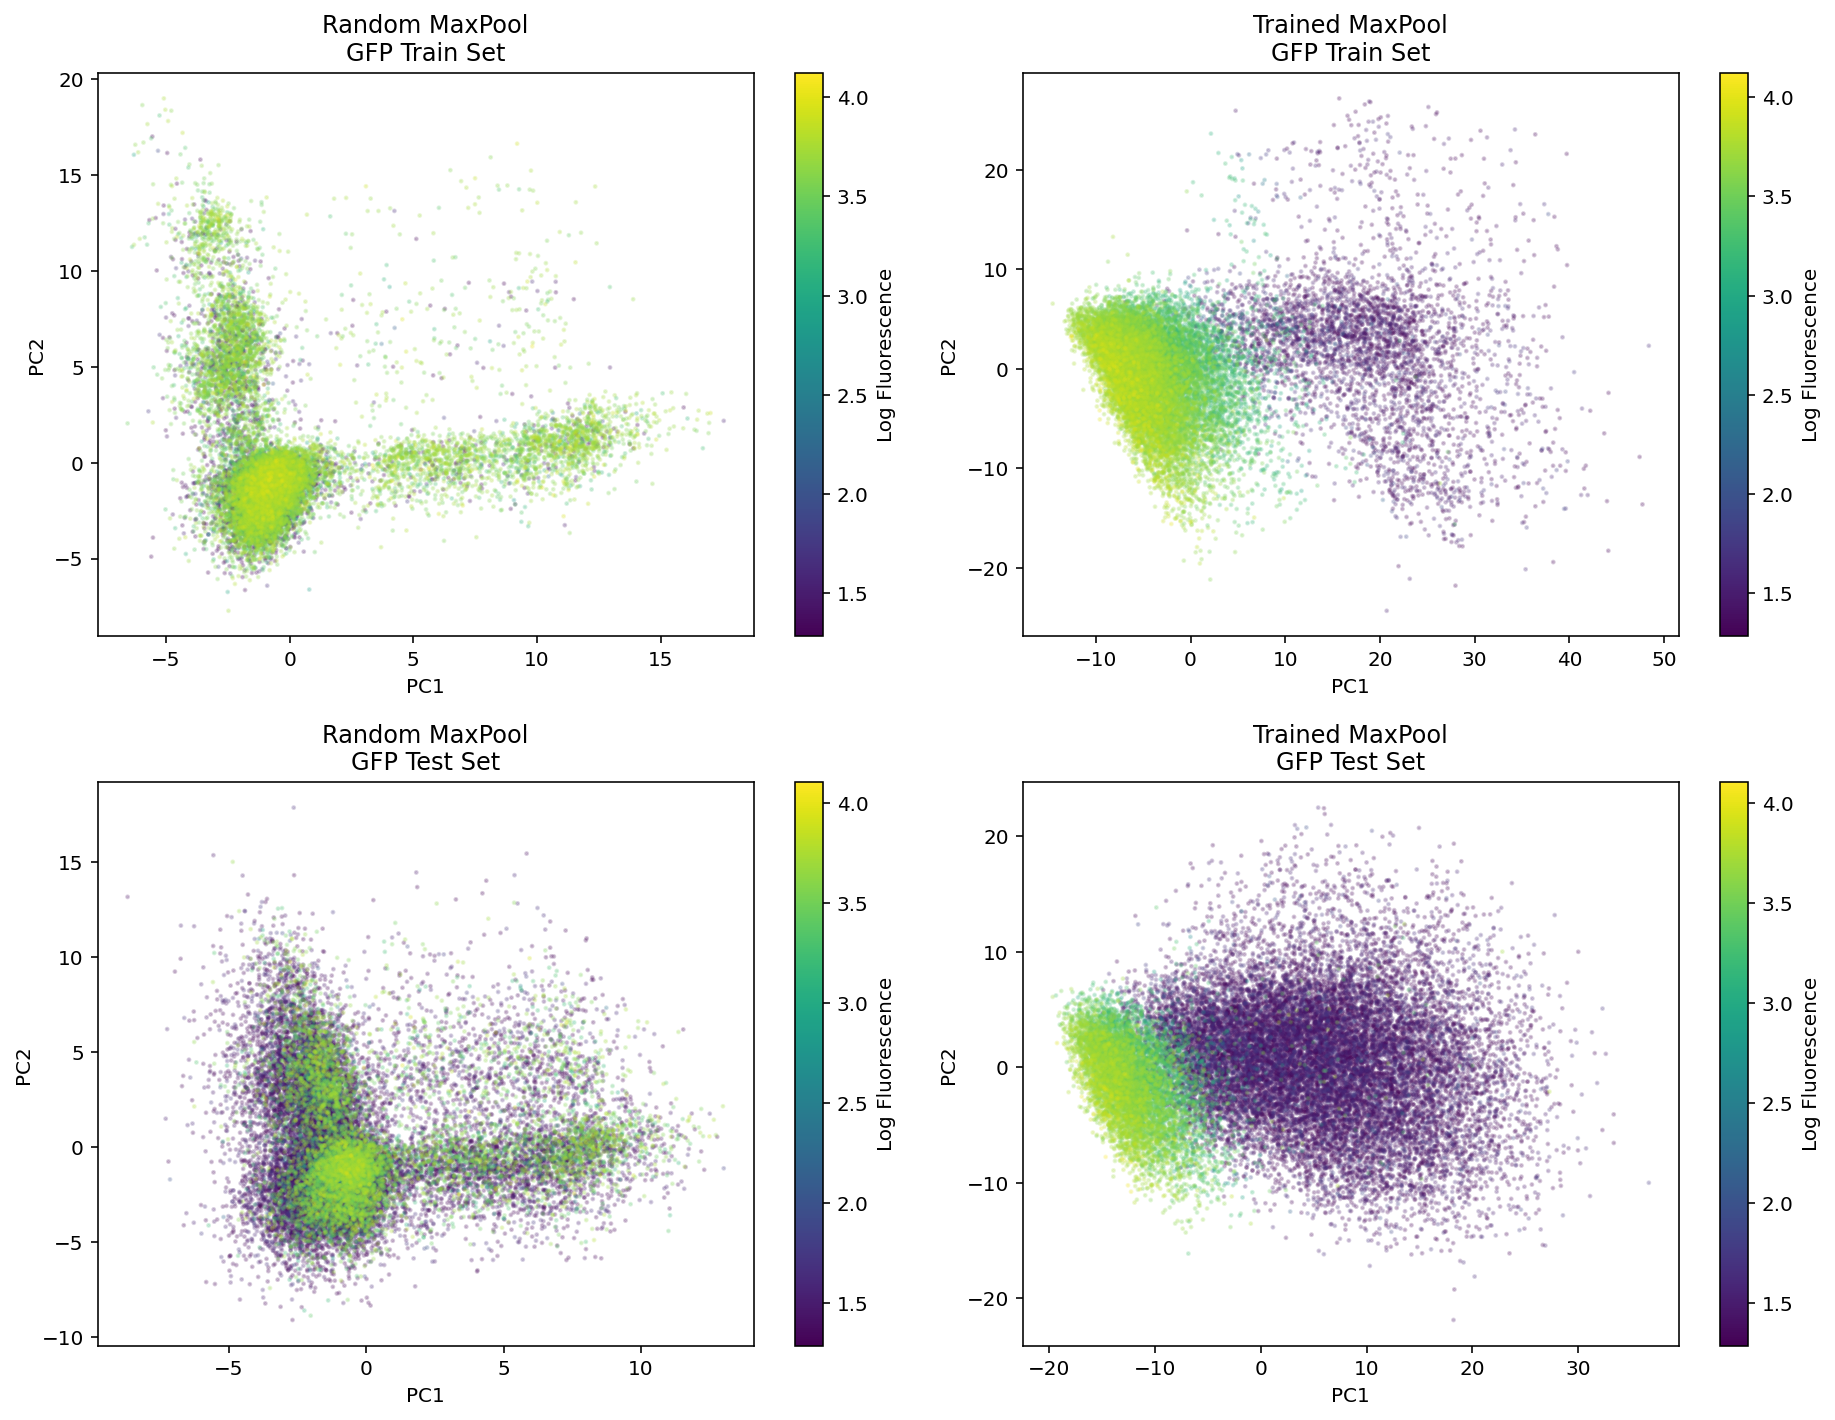

In [84]:
fig, ax = plt.subplots(2, 2, figsize=(13, 10))

models = [random_model, maxp_model]
loaders = [dm.train_dataloader(), dm.test_dataloader()]


for i, loader in enumerate(loaders):
    for j, model in enumerate(models):
         
        name = 'Random' if j == 0 else 'Trained'
        load = 'Train Set' if i == 0 else 'Test Set'
        title = f'{name} MaxPool\nGFP {load}'
        
        embeddings, y_vals = get_embeddings(model, loader, device)
        plot_embeddings(embeddings, y_vals, ax[i, j])
        ax[i, j].set_title(title)
        
plt.tight_layout()